In part 1, we ourselves created the additional features (x^2, x^3). Wouldn't it be nice if we create activation functions to do just that and let the neural network decide the weights for connections during training.
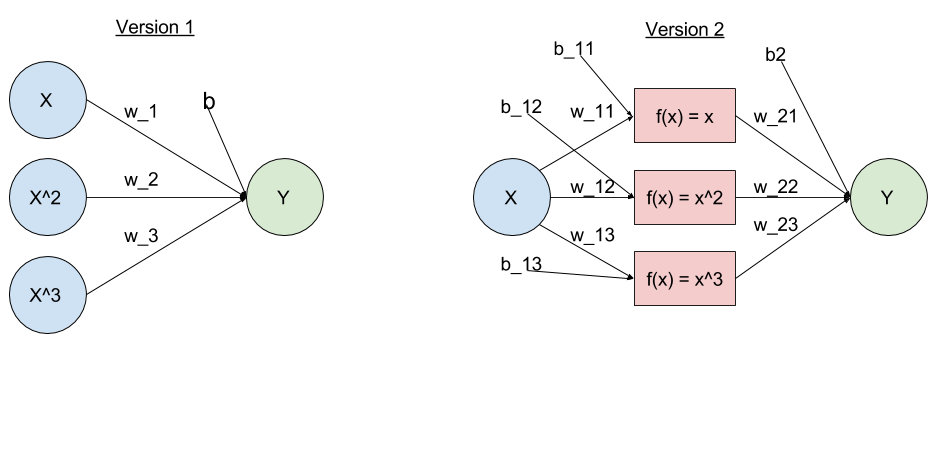

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [89]:
# Setup the training and test tensors
# Let's generate 400 examples
N = 400
x = np.random.uniform(low=-75, high=100, size=N)
y = 2*x

X_tensor = Variable(torch.FloatTensor(x), requires_grad=False)
y_tensor = Variable(torch.FloatTensor(y), requires_grad=False)

# Test set initialization
x_test = np.array([-2.5, 0.0, 19])
X_test_tsr = Variable(torch.FloatTensor(x_test), requires_grad=False)

### Time to create our x^n activation function

In [152]:
class PowerNet(torch.nn.Module):
    def __init__(self, n):
        super(PowerNet, self).__init__()
        self.n = n
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x).pow(self.n)

class Pow123Net(torch.nn.Module):
    def __init__(self):
        super(Pow123Net, self).__init__()
        self.p1 = PowerNet(1)
        self.p2 = PowerNet(2)
        self.p3 = PowerNet(3)
        
    def forward(self, x):
        x1 = self.p1.forward(x)
        x2 = self.p2.forward(x)
        x3 = self.p3.forward(x)
        return torch.cat((x1, x2, x3), 1)

In [163]:
# Implement version-2 neural network
import math
from time import time
from collections import OrderedDict

def RunV2NNTraining(X, y, learning_rate=1e-5, epochs=5000, batch_size=None, X_test=None, 
                        use_optimizer=None, adam_betas=(0.9, 0.999)):
    # Neural Net
    X_size = X.size()
    N = X_size[0]
    D_out = 1
    
    model = torch.nn.Sequential(OrderedDict([
        ("Pow123Net", Pow123Net()),
        ("FC", torch.nn.Linear(3, D_out))]
    ))
    
    loss_fn = torch.nn.MSELoss(size_average=True)
    
    # Choose Optimizer
    optimizer = None
    if use_optimizer:
        if use_optimizer == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=adam_betas)
        elif use_optimizer == 'Adadelta':
            optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'ASGD':
            optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        elif use_optimizer == 'Adagrad':
            optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
        else:
            print("Invalid Optimizer")
            use_optimizer=None
    
    losses = []
    loss = None
    start_time = time()
    for t in range(epochs):
        num_batches = 1
        X_batch = None
        y_batch = None
        if batch_size:
            num_batches = math.ceil(N/batch_size)
        else:
            batch_size = N
        
        shuffle = torch.randperm(N)
        
        for b in range(num_batches):
            lower_index = b*batch_size
            upper_index = min(lower_index+batch_size, N)
            indices = shuffle[lower_index:upper_index]
            X_batch = X[indices]
            y_batch = y[indices]
                        
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            if use_optimizer:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                # Zero the gradients before running the backward pass.
                model.zero_grad()
                loss.backward()

                # Update the weights using gradient descent. Each parameter is a Variable, so
                # we can access its data and gradients like we did before.
                for param in model.parameters():
                    param.data -= learning_rate * param.grad.data
        losses.append(loss.data[0])

    end_time = time()
    time_taken = end_time - start_time
    print("Time Taken = %.2f seconds " % time_taken)
    print("Final Loss: ", loss.data[0])
    print("Parameters [w_1, w_2, w_3, b]: ")
    for name, param in model.named_parameters():
        print(name)
        print(param.data)

    # plot Loss vs Iterations
    plt.plot(losses)
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    # Predictions on Test set
    if X_test:
        print("Test:")
        print("X_test: ", X_test.data)
        print("y_pred: ", model(X_test))

Time Taken = 11.21 seconds 
Final Loss:  2.307065614104431e-07
Parameters [w_1, w_2, w_3, b]: 
Pow123Net.p1.linear.weight

 2.9124
[torch.FloatTensor of size 1x1]

Pow123Net.p1.linear.bias

 0.5848
[torch.FloatTensor of size 1]

Pow123Net.p2.linear.weight

 0.2350
[torch.FloatTensor of size 1x1]

Pow123Net.p2.linear.bias

-0.3395
[torch.FloatTensor of size 1]

Pow123Net.p3.linear.weight

 0.1070
[torch.FloatTensor of size 1x1]

Pow123Net.p3.linear.bias

-0.3338
[torch.FloatTensor of size 1]

FC.weight

 6.8673e-01  1.9410e-07  1.2253e-06
[torch.FloatTensor of size 1x3]

FC.bias

-0.4016
[torch.FloatTensor of size 1]



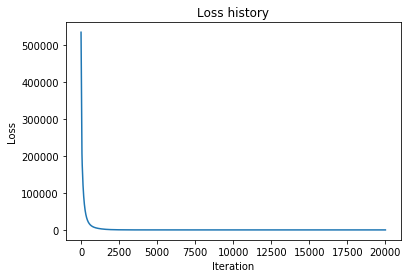

Test:
X_test:  
 -2.5000
  0.0000
 19.0000
[torch.FloatTensor of size 3x1]

y_pred:  Variable containing:
-5.0000e+00
 1.8179e-06
 3.8000e+01
[torch.FloatTensor of size 3x1]



In [165]:
# use_optimizer can be Adam, RMSprop, Adadelta, ASGD, SGD, Adagrad
RunV2NNTraining(X=X_tensor.view(-1,1), y=y_tensor, batch_size=None, epochs=20000, learning_rate=1e-3, 
                    X_test=X_test_tsr.view(-1,1), use_optimizer='Adam')